# Code Overview: Scatterplot Pipeline

This code implement a complete pipeline to analyse environmental data by comparing model predictions with ground truth and NO₂ measurements. It performs the following steps

1. **Data Loading:**  
   - Loads a campaign CSV dataset containing environmental measurements.
   - Loads a pre-trained Keras model.
   - Loads a NO₂-CSV dataset.

2. **Preprocessing:**  
   - Converts timestamps and normalizes ground-truth labels.
   - Determines the feature columns for model inference.

3. **Model Inference & Aggregation:**  
   - Runs model predictions every 5 seconds.
   - Aggregates the predictions into 2-minute intervals by computing the mode (most frequent predicted class) and the average confidence

4. **Ground Truth Aggregation:**  
   - mapps true labels to numerical values.
   - Aggregates the ground truth labels into 2-minute interval.

5. **NO₂ Data Processing:**  
   - Loads NO₂ measurements and aggregates them in 2-minute intervals.

6. **Data Fusion & Analysis:**  
   - Merges the aggregated predictions and ground truth with the NO₂ data.
   - Computes the mean and standard deviation of NO₂ values per class for both predictions and ground truth.

7. **Visualization:**  
   - Plots a comparison (error bars too) of the mean NO₂ levels for each class (predicted vs true) including a diagonal reference line (y = x).

**Important:**  
To run this code and reproduce the results, first you must download the necessary files from the repo:
- **Campaign Dataset:** from `dataset/Campaign_Dataset`
- **NO₂ Dataset:** from `dataset/Airquix_Data`
- **Pre-trained Model:** from the `/models` directory

Model successfully loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━

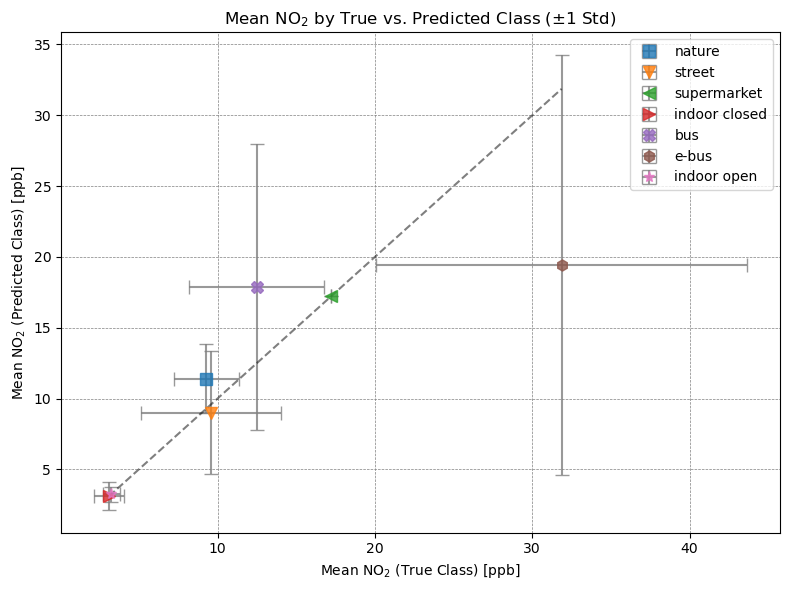

In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1) Daten laden (Prediction-CSV, Keras, NO2)
# -------------------------------------------------
CSV_PATH = r"C:\Users\lpera\OneDrive\Desktop\AirquixAppThesis\dataset\Campaign_Dataset\campaign_01.csv"
MODEL_PATH = r"C:\Users\lpera\OneDrive\Desktop\Uni\Kopie\1tf_nn_model.keras"
NO2_CSV_PATH = r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-19 04_01_12.csv"

df = pd.read_csv(CSV_PATH, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['status_gt'] = df['status_gt'].astype(str).str.strip().str.lower()

# Label-Mapping
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Optionale Kurz-Bezeichnungen
short_label_mapping = {
    "vehicle in subway": "subway",
    "outdoor on foot": "street",
    "indoor in supermarket": "supermarket",
    "vehicle in tram": "tram",
    "indoor with window closed": "indoor closed",
    "indoor in subway-station": "subway-station",
    "vehicle in subway (old)": "subway old",
    "vehicle in bus": "bus",
    "vehicle in e-bus": "e-bus",
    "outdoor in nature": "nature",
    "indoor with window open": "indoor open"
}

# Bestimme Feature-Spalten
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras Model laden
model = tf.keras.models.load_model(MODEL_PATH)
print("Model successfully loaded.")

# -------------------------------------------------
# 2) Inferenz (5-Sekunden Takt) + Aggregation
# -------------------------------------------------
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# Aggregation auf 2-Minuten-Basis: Vorhergesagte Klasse (Modus)
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# -------------------------------------------------
# 3) Ground Truth ebenfalls auf 2-Minuten-Basis
# -------------------------------------------------
# (A) Numerische Klassen
df['true_status_num'] = df['status_gt'].map(label_mapping)

# (B) Aggregation pro 2 Minuten (GT-Klasse)
df['minute'] = df['timestamp'].dt.floor('2min')
true_minute = df.groupby('minute').agg(
    true_mode_status=pd.NamedAgg(column='true_status_num', aggfunc=lambda x: x.mode().iloc[0])
).reset_index()

# -------------------------------------------------
# 4) NO2 Daten laden und auf 2-Minuten mitteln
# -------------------------------------------------
df_no2 = pd.read_csv(NO2_CSV_PATH, parse_dates=["Time"]).sort_values(by="Time")

manual_start_time = pd.Timestamp("2025-02-18 13:35:00")

# Filter
pred_minute_filtered = pred_minute[pred_minute['minute'] >= manual_start_time].copy()
true_minute_filtered = true_minute[true_minute['minute'] >= manual_start_time].copy()

df_no2_filtered = df_no2[df_no2['Time'] >= manual_start_time].copy()
df_no2_filtered['minute'] = df_no2_filtered['Time'].dt.floor('2min')

no2_agg_2min = df_no2_filtered.groupby('minute')['no2_aq10'].mean().reset_index()
no2_agg_2min.rename(columns={'no2_aq10': 'no2_mean'}, inplace=True)

# -------------------------------------------------
# 5) Merge: NO2 + Predictions
# -------------------------------------------------
merged_pred = pd.merge(
    pred_minute_filtered[['minute','pred_mode_class']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

# Merge: NO2 + Ground Truth
merged_gt = pd.merge(
    true_minute_filtered[['minute','true_mode_status']],
    no2_agg_2min,
    on='minute',
    how='inner'
)

# -------------------------------------------------
# 6) Mittelwert/Std NO2 pro Klasse (Pred + GT)
# -------------------------------------------------
stats_pred = merged_pred.groupby('pred_mode_class')['no2_mean'].agg(['mean','std']).reset_index()
stats_pred.rename(columns={'mean':'mean_pred','std':'std_pred','pred_mode_class':'class_id'}, inplace=True)

stats_gt = merged_gt.groupby('true_mode_status')['no2_mean'].agg(['mean','std']).reset_index()
stats_gt.rename(columns={'mean':'mean_gt','std':'std_gt','true_mode_status':'class_id'}, inplace=True)

# (A) Merge beider Stats: pro class_id => mean_pred, std_pred, mean_gt, std_gt
stats_both = pd.merge(stats_pred, stats_gt, on='class_id', how='outer').fillna(0)

# Optionale Sortierung nach class_id
stats_both.sort_values(by='class_id', inplace=True)

# Beispiel: Dictionary oder Liste an Markern für max. 11 Klassen
markers = ["o", "s", "^", "v", "D", "<", ">", "p", "X", "h", "*"]

def get_short_label(class_id):
    """Klassen-ID -> Kurzname."""
    original_name = inv_label_mapping.get(class_id, "Unknown")
    return short_label_mapping.get(original_name, original_name)

# 1) Figure anlegen
fig, ax = plt.subplots(figsize=(8, 6))

# 2) Pro Klasse separat plotten
unique_classes = stats_both['class_id'].unique()
unique_classes = np.sort(unique_classes)  # optional: sortieren

for c in unique_classes:
    # Datenzeilen für Klasse c
    data_c = stats_both[stats_both['class_id'] == c]
    
    # x/y + Fehlerbalken
    x = data_c['mean_gt']
    y = data_c['mean_pred']
    xerr = data_c['std_gt']
    yerr = data_c['std_pred']
    
    # Marker wählen (ggf. fallback, wenn c >= len(markers))
    marker_c = markers[c] if c < len(markers) else "o"
    
    # Klassenname für die Legende
    label_c = get_short_label(c)

    ax.errorbar(
        x, y,
        xerr=xerr, yerr=yerr,
        fmt=marker_c, capsize=5,
        ecolor='gray', markersize=8,
        alpha=0.8,
        label=label_c  # -> Legendeintrag
    )

# 3) Diagonale y=x
all_x = stats_both['mean_gt']
all_y = stats_both['mean_pred']
min_val = min(all_x.min(), all_y.min())
max_val = max(all_x.max(), all_y.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# 4) Achsenbeschriftung und Titel (mit Einheit [aq10])
ax.set_xlabel("Mean NO$_2$ (True Class) [ppb]")
ax.set_ylabel("Mean NO$_2$ (Predicted Class) [ppb]")
ax.set_title("Mean NO$_2$ by True vs. Predicted Class (±1 Std)")

# 5) Legende
ax.legend(loc='best')

# Gitternetzlinien hinzufügen
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

# 6) Layout und Plot speichern
plt.tight_layout()
plt.savefig("mean_NO2_pred_vs_true.png", dpi=300, bbox_inches="tight")

# 7) Plot anzeigen
plt.show()
